* [1.Description des données](#dd)
* [2.Nettoyage](#ne)
* [3.Choix des variables cibles (les émissions de CO2 et  la consommation totale d’énergie)](#cv)
* [4.Analyse exploratoire](#ae)
* [5.Sauvegarde des données dans un fichier csv](#cs)

In [1]:
import pandas as pd
import numpy as np

import missingno as msno
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['axes.grid'] = True
import folium
from folium import plugins

from sklearn.preprocessing import QuantileTransformer
from scipy.special import boxcox1p
from scipy.stats import skew,boxcox_normmax
import warnings
warnings.filterwarnings('ignore')
rng = np.random.RandomState(304)

# Fonctions utilisateurs

In [2]:
############Fonction affichant les variables corrélés en fixant un seuil
def f_strong_correlation(threshold_up ,df2):
    #threshold_up = 0.7
    corr_pairs = df2.corr().unstack().sort_values(kind="quicksort")
    strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold_up)])
               .reset_index().rename(columns={0:'corr_coeff'}))
    strong_corr = strong_corr[(strong_corr.index%2 == 0) & 
                          (strong_corr['level_0'] != strong_corr['level_1'])]
    strong_corr.sort_values('corr_coeff', ascending=False)
    return strong_corr
###################Fonction pour transformer skewed variables
def f_transf_skew(df,variables,method):
    
    for col in variables:
        if method=='log':
            z=np.log(df[col]+1)
        elif method=='sqrt':
            z=np.sqrt(df[col])
        elif method=='cube_root':
            z=df[col]**(1/3)
        elif method=='boxcox':
            z=boxcox1p(df[col], boxcox_normmax(df[col] + 1))
        elif method=='quantile': 
            quantile=QuantileTransformer(n_quantiles=500, output_distribution='normal')
            data=np.array(df[col]).reshape(-1, 1)
            z=quantile.fit_transform(data)
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        sns.histplot(df[col],ax=axes[0], color="blue", kde=True, stat="density", linewidth=0)
        sns.histplot(z,ax=axes[1], color="red",  kde=True, stat="density", linewidth=0)
        old_skew=df[col].skew()
        df[col]=z
        new_skew=df[col].skew()
        print(f"Skewness of {col} was {round(old_skew,2)} before & is {round(new_skew,2)} after {method} transformation.")
        #df[col]=z
    return df
##############""fonction pour afficher les valeurs numeriques high skewed selon un seuil



def f_high_skewed_feature(df,num_feats,threshold=0.3):
    skew_feats=df[num_feats].skew().sort_values(ascending=False)
    high_skew = skew_feats[np.abs(skew_feats) > threshold]
    df_high_skew=pd.DataFrame( {'Skew_value':high_skew})
    df_high_skew = df_high_skew.rename_axis(['Feature']).reset_index()
    return df_high_skew

# 1.Description des données <a class="anchor" id="dd"></a>

In [3]:
df=pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [4]:
df.shape

(3376, 46)

In [5]:
df.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

In [6]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [7]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [8]:
#batiments non destinés à l'habitation
df = df[~df['BuildingType'].str.contains("Multifamily")]
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

<AxesSubplot:>

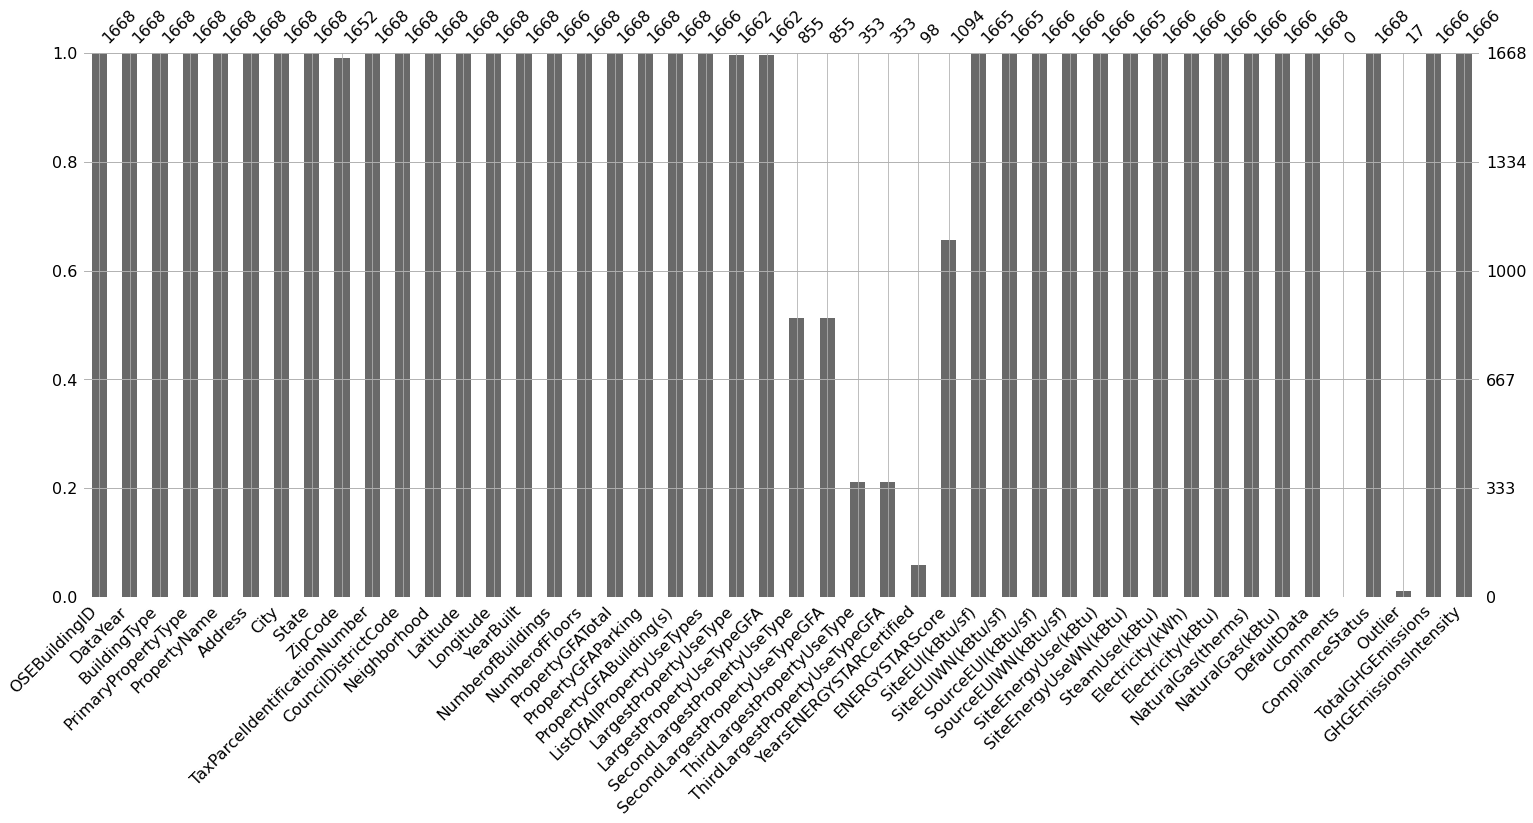

In [9]:
msno.bar(df)

In [10]:
#Vérification de l'emplacement
import folium
map = folium.Map()
map = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()],zoom_start=10)
for i in range(0,len(df)):
    folium.Circle([df.iloc[i]['Latitude'],df.iloc[i]['Longitude']], 
                      popup=df.iloc[i]['Address'], radius =100).add_to(map)
map

**Observation**
<br>
Il s'agit bien des batiments dans Seattle

# 2.Choix des variables cibles (les émissions de CO2 et la consommation totale d’énergie)

In [11]:
target1='TotalGHGEmissions'
target2='SiteEnergyUse(kBtu)'

# 3.Nettoyage<a class="anchor" id="ne"></a>

In [12]:
df.shape

(1668, 46)

In [13]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

### Suppression de quelques variables

In [14]:
# suppressions des variables qui ne nous intéressent pas
df.drop(['State','ZipCode','City'], axis=1, inplace=True)#deja State et City ont chacun une seule valeur

In [15]:
df.shape

(1668, 43)

In [16]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'TaxParcelIdentificationNumber',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier',
       'TotalGHGEmissions', 'GHG

In [17]:
columns_to_drop = ['PropertyName', #similaire à ID
                   'TaxParcelIdentificationNumber', #similaire à ID
                 

                   'NaturalGas(therms)',
                   'Electricity(kWh)',
                   
                   'Comments',#vide
                   'DefaultData', #utilité de la variable inconnue
                   'Address', #non conservé (latitude et longitude préférées)
                   'CouncilDistrictCode',
                   
                   'YearsENERGYSTARCertified', #données incomplètes
                   'SiteEUI(kBtu/sf)'#calculable a partir de SiteEnergyUse(kBtu)                  
                  ]

In [18]:
#supprimer la colonne Comments qui est vide
df = df.drop(columns_to_drop, axis=1)

In [19]:
df.shape

(1668, 33)

In [20]:
#Suppression des variables avec suffixe WN qui indiquent Weather Normalized
def find_component(df, suffix=None):
    componant = []
    for col in df.columns:
        if suffix in col: 
            componant.append(col)
    return componant
df.drop(find_component(df,'WN'), axis=1, inplace=True)

In [21]:
df.shape

(1668, 30)

In [22]:
df.shape

(1668, 30)

### Suppression de quelques lignes

In [23]:
#Vérification des valeurs négatives
df.min()

OSEBuildingID                                        1
DataYear                                          2016
BuildingType                                    Campus
PrimaryPropertyType                Distribution Center
Neighborhood                                   BALLARD
Latitude                                      47.49917
Longitude                                   -122.41182
YearBuilt                                         1900
NumberofBuildings                                  0.0
NumberofFloors                                       0
PropertyGFATotal                                 11285
PropertyGFAParking                                   0
PropertyGFABuilding(s)                            3636
LargestPropertyUseTypeGFA                       5656.0
SecondLargestPropertyUseTypeGFA                    0.0
ThirdLargestPropertyUseTypeGFA                     0.0
ENERGYSTARScore                                    1.0
SourceEUI(kBtu/sf)                                 0.0
SiteEnergy

In [24]:
#supprimer les lignes avec TotalGHGEmissions<=0
df = df[df['TotalGHGEmissions'] >0]
df.shape

(1659, 30)

In [25]:
df = df[df['GHGEmissionsIntensity'] >0]
df.shape

(1657, 30)

In [26]:
df = df[df['SiteEnergyUse(kBtu)'] >0]
df.shape

(1646, 30)

In [27]:

df = df[df['SourceEUI(kBtu/sf)'] >0]
df.shape

(1645, 30)

In [28]:
#supprimer les lignes contenat que des nan
df.dropna(how = 'all', axis=0, inplace=True)
df.shape

(1645, 30)

In [29]:
#supprimer les lignes avec target1 à nan
df = df[df[target1].notna()]
df.shape

(1645, 30)

In [30]:
#supprimer les lignes avec target2 à nan
df = df[df[target2].notna()]
df.shape

(1645, 30)

In [31]:
df['Outlier'].unique() #trop de données manquantes

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [32]:
df=df[df['Outlier']!='High outlier']
df = df.drop(['Outlier'], axis=1)

In [33]:
df['ComplianceStatus'].unique() #trop de données manquantes

array(['Compliant', 'Error - Correct Default Data', 'Non-Compliant'],
      dtype=object)

In [34]:
df=df[df['ComplianceStatus']!='Error - Correct Default Data']
df = df.drop(['ComplianceStatus'], axis=1)

### Imputation

In [35]:
#un batiment a au moins NumberofBuildings=1 et NumberofFloors=1                        0
df['NumberofBuildings']=df['NumberofBuildings'].replace([0], 1)
df['NumberofFloors']=df['NumberofFloors'].replace([0], 1)

In [36]:
#Imputer les variables numériques par 0
numercial_cols = [col for col in df.columns if df[col].dtype!="O"]
df[numercial_cols]=df[numercial_cols].fillna(df[numercial_cols].mean())

In [37]:
# imputer les variables catégorielles par la valeur la plus fréquente
categoricla_cols = [col for col in df.columns if df[col].dtype=="O"]

df[categoricla_cols]=df[categoricla_cols].fillna(df.mode().iloc[0])

In [38]:
df.describe()

OSEBuildingID  DataYear     Latitude    Longitude    YearBuilt  \
count    1556.000000    1556.0  1556.000000  1556.000000  1556.000000   
mean    16518.173522    2016.0    47.616369  -122.333442  1961.389460   
std     13799.798551       0.0     0.046975     0.023271    32.927515   
min         1.000000    2016.0    47.509590  -122.411820  1900.000000   
25%       603.750000    2016.0    47.587787  -122.342885  1929.000000   
50%     21187.500000    2016.0    47.612520  -122.333160  1965.000000   
75%     24625.250000    2016.0    47.649060  -122.322613  1988.000000   
max     50226.000000    2016.0    47.733870  -122.261800  2015.000000   

       NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count        1556.000000     1556.000000      1.556000e+03   
mean            1.214010        4.276350      1.209305e+05   
std             3.025267        6.759591      3.055724e+05   
min             1.000000        1.000000      1.128500e+04   
25%             1.000000        1.000000      2.880600e+04   
50%             1.000000        2.000000      4.800350e+04   
75%             1.000000        4.000000      1.070380e+05   
max           111.000000       99.000000      9.320156e+06   

       PropertyGFAParking  PropertyGFABuilding(s)  ...  \
count         1556.000000            1.556000e+03  ...   
mean         13771.168380            1.071593e+05  ...   
std          43620.452384            2.919262e+05  ...   
min              0.000000            3.636000e+03  ...   
25%              0.000000            2.786650e+04  ...   
50%              0.000000            4.597000e+04  ...   
75%              0.000000            9.506750e+04  ...   
max         512608.000000            9.320156e+06  ...   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1556.000000                     1556.000000   
mean                      36266.253021                    15054.316181   
std                       49019.148651                    17492.469259   
min                           0.000000                        0.000000   
25%                       10413.250000                    15054.316181   
50%                       36266.253021                    15054.316181   
75%                       36266.253021                    15054.316181   
max                      639931.000000                   459748.000000   

       ENERGYSTARScore  SourceEUI(kBtu/sf)  SiteEnergyUse(kBtu)  \
count      1556.000000         1556.000000         1.556000e+03   
mean         63.921236          182.405977         8.811615e+06   
std          23.181276          187.823157         3.123174e+07   
min           1.000000            4.300000         4.429350e+04   
25%          61.000000           80.775002         1.240258e+06   
50%          63.921236          138.250000         2.701853e+06   
75%          79.000000          212.375004         7.267172e+06   
max         100.000000         2620.000000         8.739237e+08   

       SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
count    1.556000e+03       1.556000e+03      1.556000e+03        1556.000000   
mean     5.483492e+05       6.110539e+06      2.028248e+06         192.645193   
std      5.703910e+06       2.145946e+07      9.686668e+06         777.214520   
min      0.000000e+00       0.000000e+00      0.000000e+00           0.310000   
25%      0.000000e+00       7.248490e+05      0.000000e+00          20.262500   
50%      0.000000e+00       1.705598e+06      4.761960e+05          49.600000   
75%      0.000000e+00       5.238197e+06      1.528624e+06         146.947500   
max      1.349435e+08       6.570744e+08      2.979090e+08       16870.980000   

       GHGEmissionsIntensity  
count            1556.000000  
mean                1.659389  
std                 2.403940  
min                 0.010000  
25%                 0.350000  
50%                 0.880000  
75%                 1.960000  
max               

### Calcul de nouvelles variables et suppression des anciennes

In [39]:
df.insert(loc=2,
        column='%Electricity(kBtu)',
        value=round(100*df['Electricity(kBtu)']/df['SiteEnergyUse(kBtu)'],3))
df.insert(loc=3,
        column='%NaturalGas(kBtu)',
        value=round(100*df['NaturalGas(kBtu)']/df['SiteEnergyUse(kBtu)'],3))
df.insert(loc=4,
        column='%SteamUse(kBtu)',
        value=round(100*df['SteamUse(kBtu)']/df['SiteEnergyUse(kBtu)'],3))
df = df.drop(['Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)'], axis=1)

<AxesSubplot:>

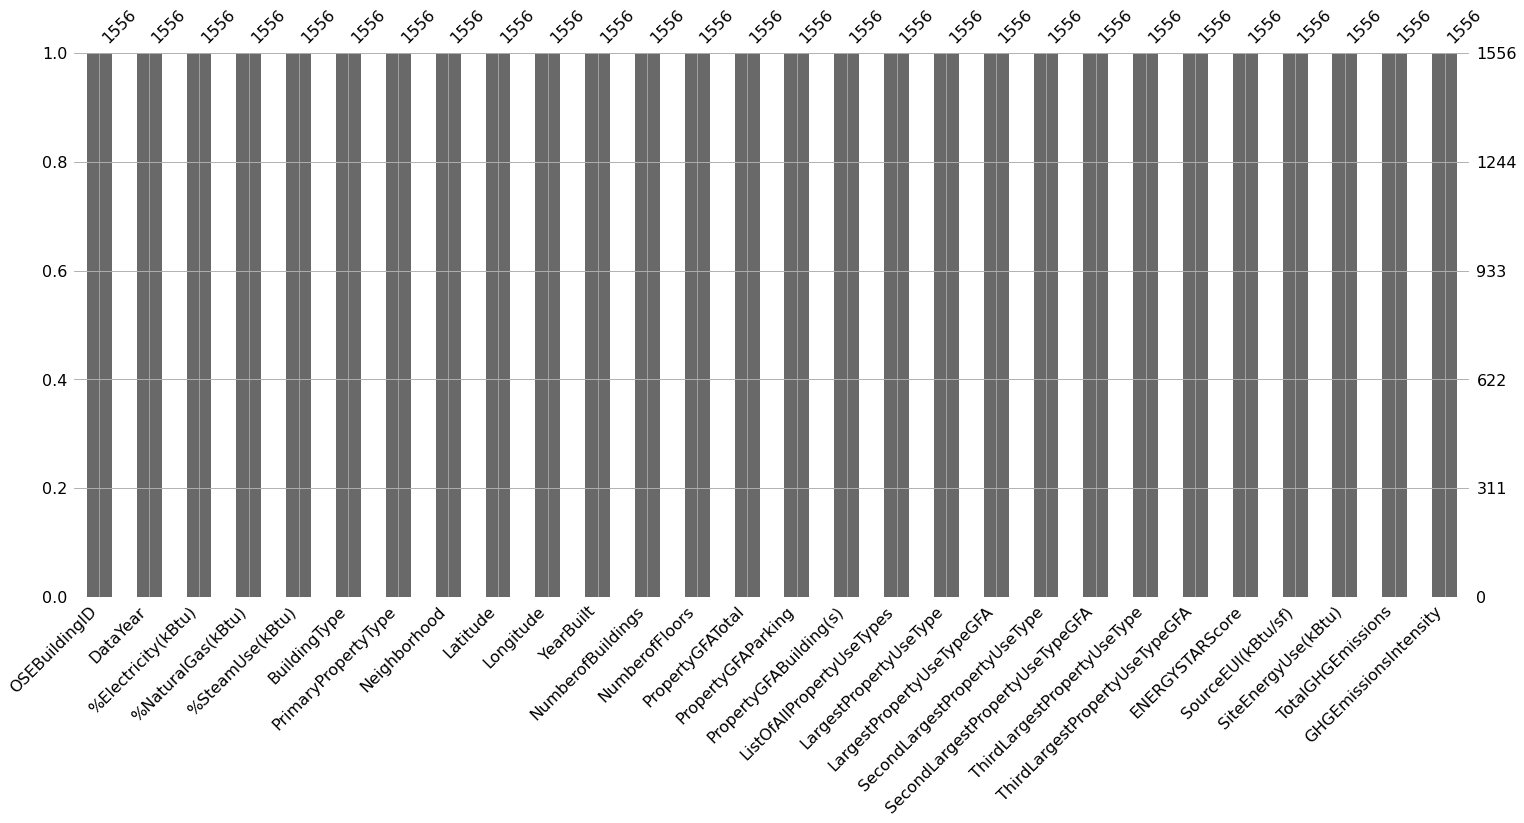

In [40]:
msno.bar(df)

# 4.Analyse exploratoire <a class="anchor" id="ae"></a>

### Analyse univariée

In [41]:
font_title = {'family': 'serif',
             'color':  '#114b98',
             'weight': 'bold',
            'size': 18,
            }

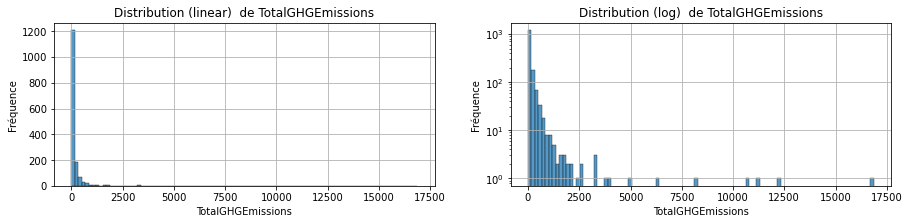

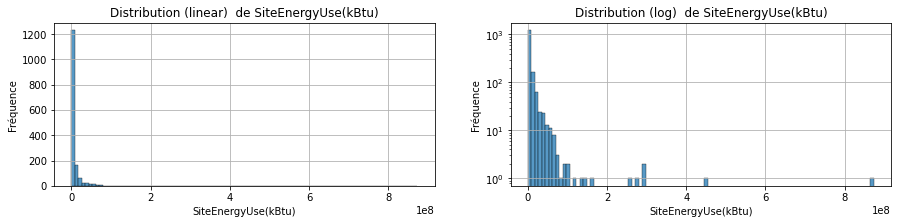

In [42]:
# distribution des cibles 

scaling=['linear','log']
targets=['TotalGHGEmissions','SiteEnergyUse(kBtu)']
nrows=2
ncols=2
for col in targets:
    plt.figure(figsize=(15, 12))        
    for i,sc in  enumerate(scaling):       
        #plt.grid()
        ax = plt.subplot(nrows, ncols, i + 1)
        plt.subplots_adjust(hspace=2)
        sns.histplot(df, x=col,ax=ax,bins=100)    
        ax.set_xlabel(col)
        ax.set_ylabel("Fréquence")
        ax.set_yscale(sc)
        ax.set_title(f'Distribution ({sc})  de {col}')   
    

    plt.show()

**Observation**
<br>
la cible 'TotalGHGEmissions' ne suit pas la loi normale.

**Observation**
<br>
la cible 'SiteEnergyUse(kBtu)' ne suit pas la loi normale.

In [43]:
DataYear=df['DataYear']

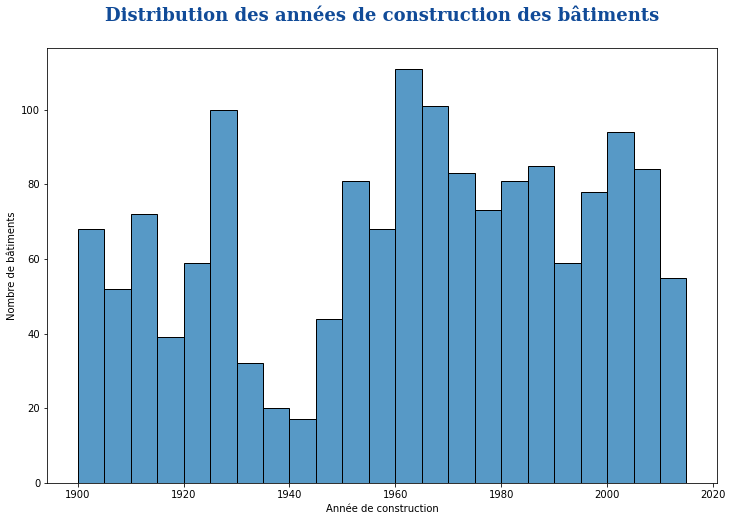

In [44]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=df, x='YearBuilt', bins=int((df.YearBuilt.max() - df.YearBuilt.min())/5))
ax.set_xlabel("Année de construction")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution des années de construction des bâtiments\n", fontdict=font_title)
plt.grid()
plt.show()

Text(0, 0.5, 'SiteEnergyUse(kBtu)')

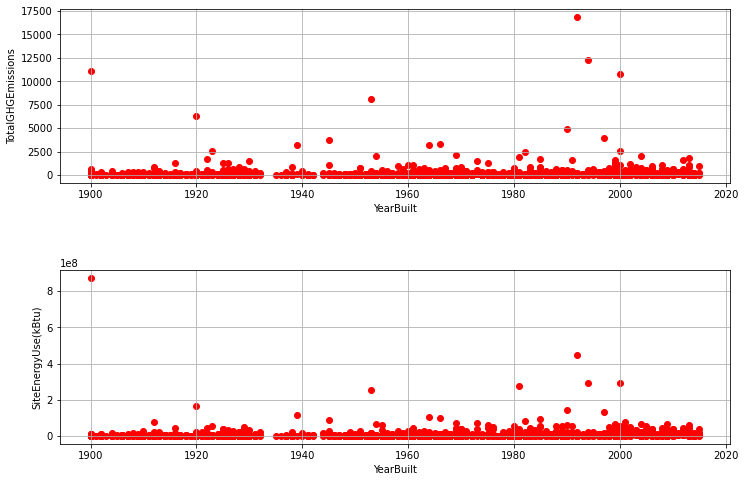

In [45]:
    
fig, ax = plt.subplots(2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)
ax[0].scatter(df['YearBuilt'],df[target1],c='red')
ax[0].set_xlabel('YearBuilt')
ax[0].set_ylabel(target1)

ax[1].scatter(df['YearBuilt'],df[target2],c='red')
ax[1].set_xlabel('YearBuilt')
ax[1].set_ylabel(target2)


**Observations**
<br>
La plupart des batiments sont construits après 1950

In [46]:
##### ajouter une colonne tranche_date selon la variale YearBuilt
df['tranche_date'] = None
df.tranche_date[df.YearBuilt < 1950] = 'tranche_date1'
df.tranche_date[(df.YearBuilt >= 1950) & (df.YearBuilt<1980)] = 'tranche_date2'
df.tranche_date[(df.YearBuilt >= 1980) & (df.YearBuilt<2000)] = 'tranche_date3'
df.tranche_date[df.YearBuilt >= 2000] = 'tranche_date4'

In [47]:
df['tranche_date'] .unique()

array(['tranche_date1', 'tranche_date3', 'tranche_date2', 'tranche_date4'],
      dtype=object)

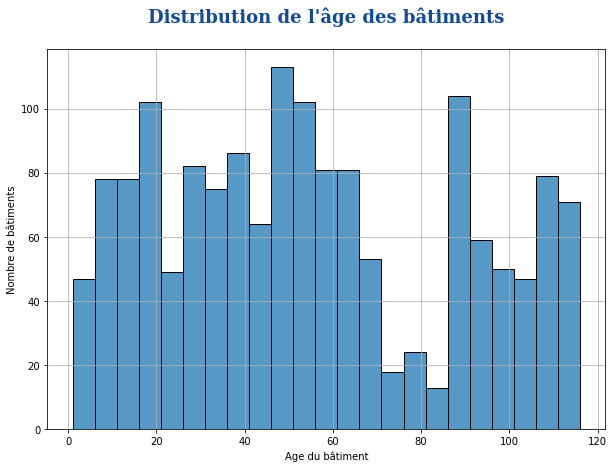

In [48]:
#Ajout de la variable age 
df['BuildingAge'] = DataYear - df['YearBuilt']
df.drop(['YearBuilt','DataYear'], axis=1, inplace=True)
  
fig = plt.figure(figsize=(10,7))
ax = sns.histplot(data=df, x='BuildingAge', bins=int((df.BuildingAge.max() - df.BuildingAge.min())/5))
ax.set_xlabel("Age du bâtiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution de l'âge des bâtiments\n", fontdict=font_title)
plt.show()

In [49]:
df.shape

(1556, 28)

Text(0, 0.5, 'SiteEnergyUse(kBtu)')

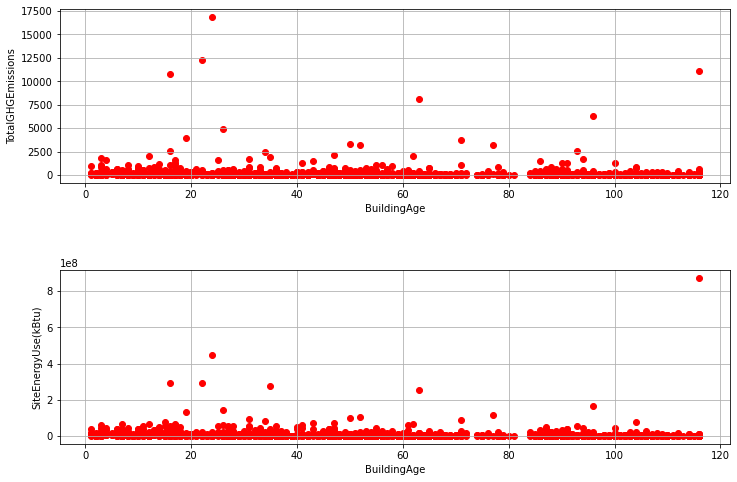

In [50]:
fig, ax = plt.subplots(2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)
ax[0].scatter(df['BuildingAge'],df[target1],c='red')
ax[0].set_xlabel('BuildingAge')
ax[0].set_ylabel(target1)

ax[1].scatter(df['BuildingAge'],df[target2],c='red')
ax[1].set_xlabel('BuildingAge')
ax[1].set_ylabel(target2)

**Observations**
<br>
La plupart des batimentssont agés moins de 70 ans.

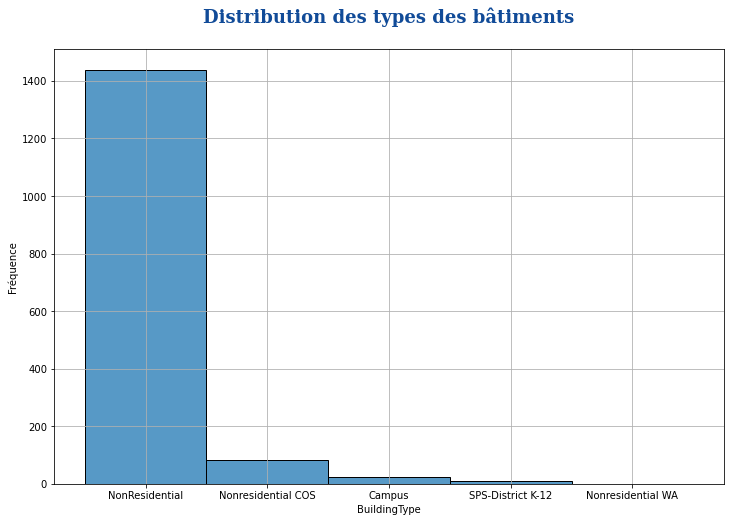

In [51]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=df, x='BuildingType')
ax.set_xlabel("BuildingType")
ax.set_ylabel("Fréquence")
plt.title(f"Distribution des types des bâtiments\n", fontdict=font_title)
plt.show()

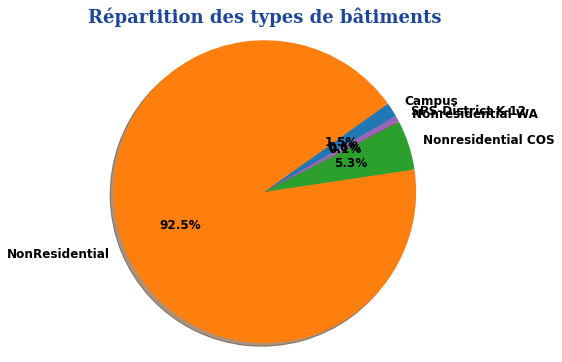

In [52]:
building_type = df.groupby(by='BuildingType')['OSEBuildingID'].nunique()
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(building_type.values, labels=building_type.index, 
       autopct='%1.1f%%', shadow=True, startangle=30,
       textprops=dict(color="black",size=12, weight="bold"))
ax.axis('equal')
ax.set_title("Répartition des types de bâtiments", fontdict=font_title)
plt.show()

**Note**
<br>
La plupart des types sont non residential
<br>
par contre nonresidential wa represente la plus petite tranche.Regardons ça de près

In [53]:
df[df['BuildingType']=="Nonresidential WA"].shape

(1, 28)

**Note**
<br>il ya une seule ligne avec "Nonresidential WA" donc on va la supprimer 

In [54]:
index_to_drop=df[df['BuildingType']=="Nonresidential WA"].index
df.drop(index_to_drop, inplace=True)
df.shape

(1555, 28)

In [55]:
df.loc[(df['BuildingType']=="NonResidential"),'PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    283
Other                          182
Warehouse                      178
Large Office                   165
Mixed Use Property             100
Retail Store                    86
Hotel                           76
Worship Facility                71
Distribution Center             51
Supermarket / Grocery Store     39
K-12 School                     39
Medical Office                  38
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             2
Name: PrimaryPropertyType, dtype: int64

**Observation**
<br>
 La plus grande part des bâtiments non résidentiels sont des bureaux de petite et moyenne taille 

**Observation**
<br> il ya des outliers apres 9.e6 ==> supprimer les lignes correspondantes

In [56]:
df[df['PropertyGFATotal']>9000000]

OSEBuildingID  %Electricity(kBtu)  %NaturalGas(kBtu)  %SteamUse(kBtu)  \
3274          49967              75.187                0.0            9.725   

     BuildingType PrimaryPropertyType Neighborhood  Latitude  Longitude  \
3274       Campus          University    NORTHEAST  47.65644 -122.31041   

      NumberofBuildings  ...  SecondLargestPropertyUseTypeGFA  \
3274              111.0  ...                     36266.253021   

      ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
3274                       Office                    15054.316181   

      ENERGYSTARScore SourceEUI(kBtu/sf) SiteEnergyUse(kBtu)  \
3274        63.921236         246.600006         873923712.0   

      TotalGHGEmissions GHGEmissionsIntensity   tranche_date BuildingAge  
3274           11140.56                   1.2  tranche_date1         116  

[1 rows x 28 columns]

**Observation**
<br>
Quelques valeurs sont beaucoup trop éloignées des autres et risquent de nous gêner dans l'analyse; nous allons les éliminer :

In [57]:
index_to_drop=df[df['PropertyGFATotal']>9000000].index
df.drop(index_to_drop, inplace=True)
df.shape

(1554, 28)

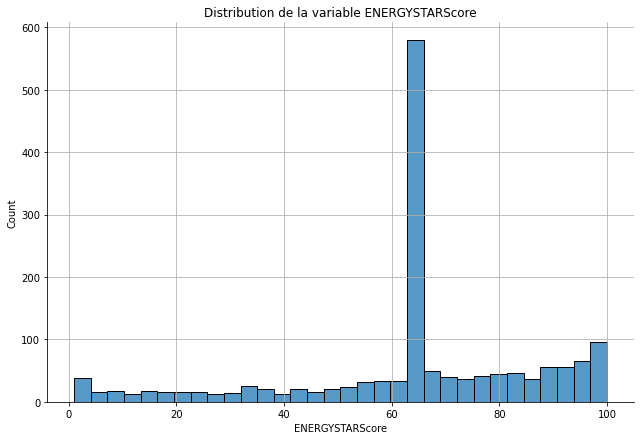

In [58]:
anaghg=sns.displot(df['ENERGYSTARScore'], palette='bright', height=6, aspect=1.5)

anaghg.set(title="Distribution de la variable ENERGYSTARScore")

**Observation**
<br>
LA plupart des patiments ont un score >50

In [59]:
df.groupby(by='BuildingType')['ENERGYSTARScore'].mean()

BuildingType
Campus                62.329663
NonResidential        63.820017
Nonresidential COS    63.245994
SPS-District K-12     87.684247
Name: ENERGYSTARScore, dtype: float64

**Observation**
<br>
Les batiments de type SPS-District K-12 ont les meillers score >85%


In [60]:
df.shape

(1554, 28)

#### Regroupement des classes

In [61]:
cat_cols = [col for col in df.columns if df[col].dtype=="O"]
cat_cols

['BuildingType',
 'PrimaryPropertyType',
 'Neighborhood',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'tranche_date']

In [62]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Campus',
       'SPS-District K-12'], dtype=object)

In [63]:
df['Neighborhood'].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'NORTHWEST', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'DELRIDGE', 'NORTH', 'North', 'Delridge',
       'Ballard', 'Northwest', 'Central', 'DELRIDGE NEIGHBORHOODS'],
      dtype=object)

In [64]:
df['groups_neighborhood'] = None
df.groups_neighborhood[df['Neighborhood']. isin(['NORTH', 'North', 'NORTHEAST', 'NORTHWEST', 'Northwest'])] = 'North'
df.groups_neighborhood[df['Neighborhood']. isin(['SOUTHEAST', 'SOUTHWEST'])] = 'South'
df.groups_neighborhood[df['Neighborhood']. isin(['CENTRAL', 'Central'])] = 'Central'
df.groups_neighborhood[df['Neighborhood']. isin( ['DELRIDGE', 'Delridge', 'DELRIDGE NEIGHBORHOODS', 'BALLARD', 'Ballard', 'DOWNTOWN', 'EAST', 
                                          'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',])] = 'Various'

df.drop(['Neighborhood'],axis=1,inplace=True)

In [65]:
df['groups_neighborhood'].unique()

array(['Various', 'North', 'Central', 'South'], dtype=object)

In [66]:
df['groups_PrimaryPropertyType'] = None
df.groups_PrimaryPropertyType[df['PrimaryPropertyType']. isin(['Hospital','Laboratory','Medical Office','Senior Care Community'])] = 'Health'
df.groups_PrimaryPropertyType[df['PrimaryPropertyType']. isin(['Retail Store','Supermarket / Grocery Store', 'Distribution Center','Restaurant',  'Refrigerated Warehouse','Warehouse','Self-Storage Facility'])] = 'Commerce'
df.groups_PrimaryPropertyType[df['PrimaryPropertyType']. isin( ['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property','Worship Facility','Residence Hall',
                 'Small- and Mid-Sized Office','Large Office','Low-Rise Multifamily','High-Rise Multifamily','Office',
                   'University', 'K-12 School'])] = 'Various'
df.drop(['PrimaryPropertyType'],axis=1,inplace=True)

In [67]:
df['groups_PrimaryPropertyType'].unique()


array(['Various', 'Commerce', 'Health'], dtype=object)

In [68]:
df.columns

Index(['OSEBuildingID', '%Electricity(kBtu)', '%NaturalGas(kBtu)',
       '%SteamUse(kBtu)', 'BuildingType', 'Latitude', 'Longitude',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'tranche_date', 'BuildingAge',
       'groups_neighborhood', 'groups_PrimaryPropertyType'],
      dtype='object')

### Analyse bivariée

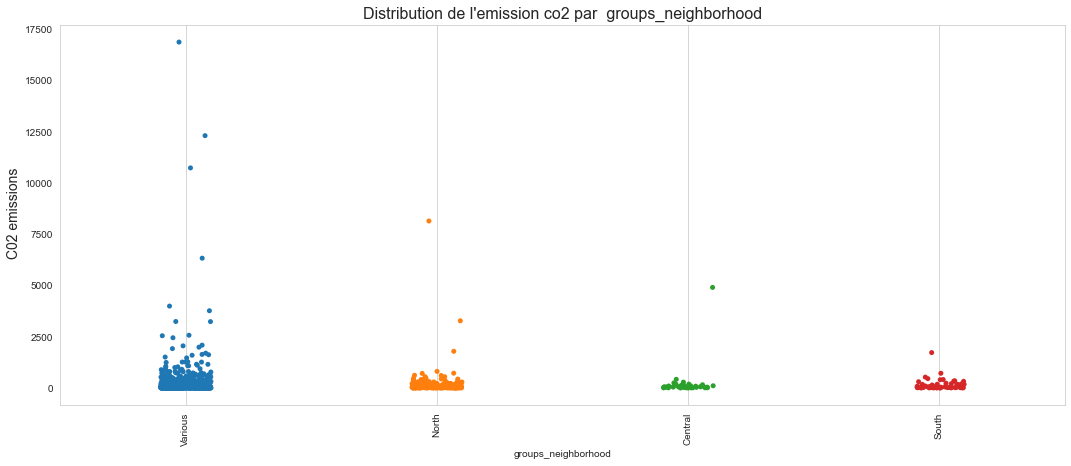

In [69]:

fig=plt.figure(figsize=[18,7])
#fig.patch.set_facecolor('#E0E0E0')
#fig.patch.set_alpha(0.7)
sns.set_style('whitegrid')
plt.title("Distribution de l'emission co2 par  {}".format('groups_neighborhood'),size=16)
#sns.boxplot(x='groups_neighborhood', y="TotalGHGEmissions", data=df,color="#cbd1db")

ax = sns.stripplot(x='groups_neighborhood', y="TotalGHGEmissions",data=df)

plt.ylabel(" C02 emissions",size=14)
plt.xticks(range(0,len(df['groups_neighborhood'].unique()))
               ,df['groups_neighborhood'].unique(),rotation=90)

plt.grid()
plt.show()

In [70]:
df[df["TotalGHGEmissions"]>2500].shape

(13, 28)

**Observation** 
<br>
il ya que 14 ligne dont la consommation de co2est >2500 (ce qui represente 0.84% des donnés).
<br>
A supprimer

In [71]:
df=df[df["TotalGHGEmissions"]<=2500]

Text(0.5, 1.0, 'TotalGHGEmissions vs SiteEnergyUse(kBtu)')

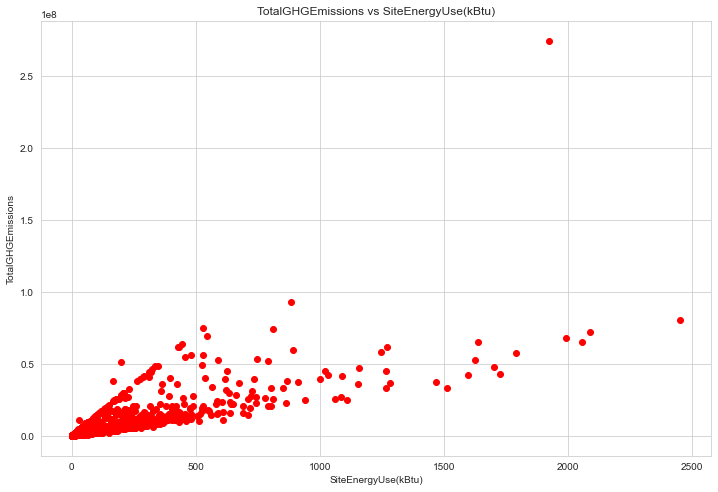

In [72]:
#Relation entre les deux cibles
plt.figure( figsize=(12, 8))
plt.scatter(df[target1],df[target2],c='red')
plt.xlabel(target2)
plt.ylabel(target1)
plt.title(f"{target1} vs {target2}")

### Analyse multivariée

**Observation**

In [73]:
df.columns

Index(['OSEBuildingID', '%Electricity(kBtu)', '%NaturalGas(kBtu)',
       '%SteamUse(kBtu)', 'BuildingType', 'Latitude', 'Longitude',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'tranche_date', 'BuildingAge',
       'groups_neighborhood', 'groups_PrimaryPropertyType'],
      dtype='object')

In [74]:
numercial_cols = [col for col in df.columns if df[col].dtype!="O"]
numercial_cols

['OSEBuildingID',
 '%Electricity(kBtu)',
 '%NaturalGas(kBtu)',
 '%SteamUse(kBtu)',
 'Latitude',
 'Longitude',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SourceEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'BuildingAge']

In [75]:
target2

'SiteEnergyUse(kBtu)'

In [76]:
df['BuildingAge'].unique()

array([ 89,  20,  47,  90,  36,  17, 112,  18,  88,  94,  12,  86,  33,
       109, 100,  31,  15,  25,  38, 110,  22,  61,  55,  26, 116,  62,
       105,  43,  96, 106,  34, 108,  57,  16,  19,  54,  46,   8,  51,
        87,   6,  78,  30,  14,  93,  13,  75,  10, 101,  66,  58,   7,
         5,  45,   9,  65,  52,  79,  50,  59,  48,  92,  11,  85,  44,
        64, 102, 103,  21,  35,  27,  91,  40, 107,  28,  37,  69,  32,
        60, 104,  39,  56,  71,  24,  53,  42,  41,  70,  49,  29,  67,
        76,  63,  84,  68,  23,  98, 111, 114,  95,  77,  72,  99,  74,
       113,   4,   3,  97, 115,  80,  81,   2,   1], dtype=int64)

In [77]:
cat_cols = [col for col in df.columns if df[col].dtype=="O"]


In [78]:
cat_cols_scatter=list(set(cat_cols)-set([ 'ListOfAllPropertyUseTypes','LargestPropertyUseType','SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']))
                      

In [79]:
var_to_scatter_targets=list(set(numercial_cols)-set(['OSEBuildingID', 'Latitude', 'Longitude','LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',target1,target2]))
list(var_to_scatter_targets)

['PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 '%NaturalGas(kBtu)',
 'ENERGYSTARScore',
 '%Electricity(kBtu)',
 'GHGEmissionsIntensity',
 '%SteamUse(kBtu)',
 'NumberofBuildings',
 'SourceEUI(kBtu/sf)',
 'BuildingAge',
 'NumberofFloors']

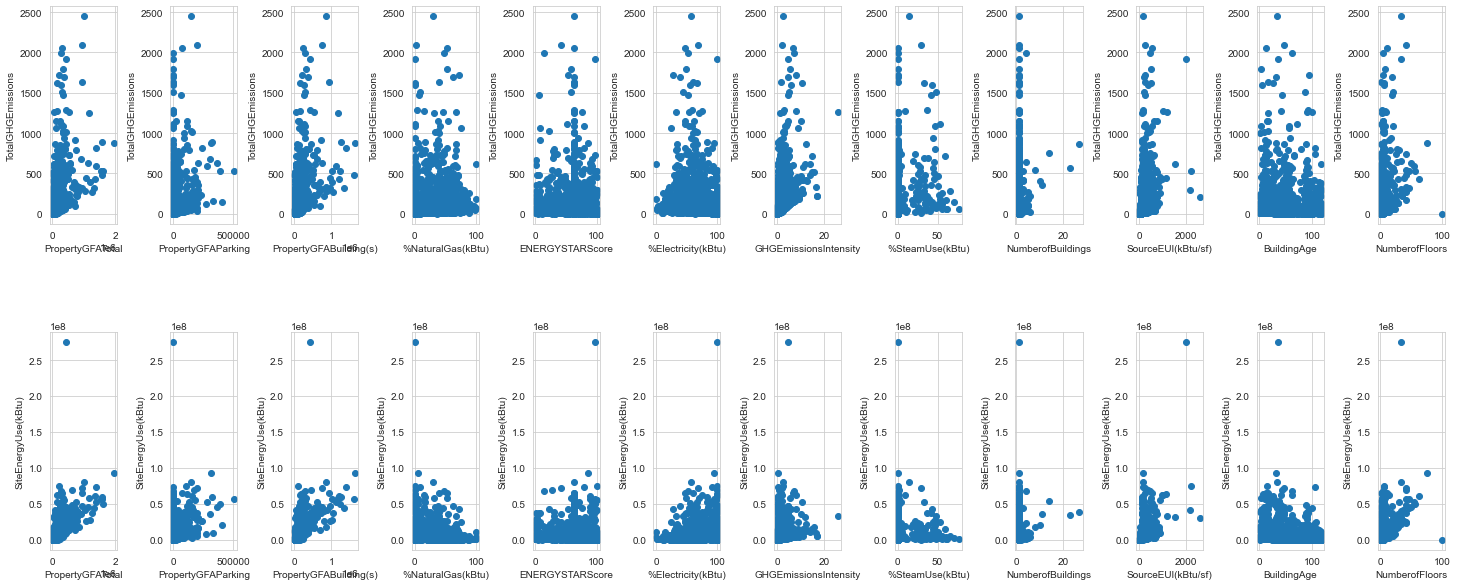

In [80]:
fig, ax = plt.subplots(2, len(var_to_scatter_targets), figsize = (25, 10))
row=0
for target in targets:
    
    for idx, col in enumerate(var_to_scatter_targets, 0):
        ax[row][idx].plot( df[col],df[target], 'o')
        ax[row][idx].set_xlabel(col)
        ax[row][idx].set_ylabel(target)
        plt.subplots_adjust(wspace=0.8,hspace=0.5)
    row=row+1


In [81]:
   def plot_scatter(hu,x1,y1):
        plt.figure(figsize = (5,3))
        
        g=sns.scatterplot(x=x1, y=y1, hue=hu,
              data=df, 
                     legend='full')
        g.set(xscale="log")
   
        plt.show()
        

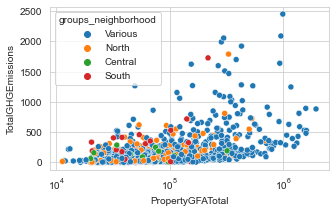

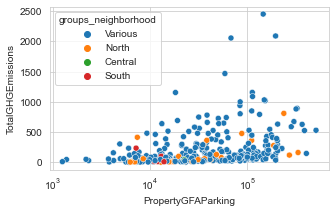

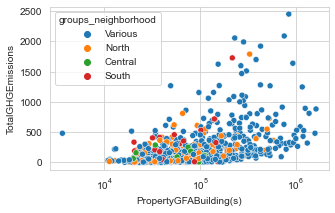

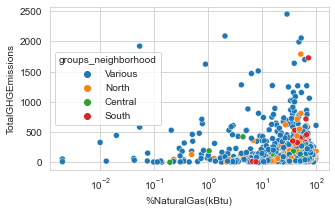

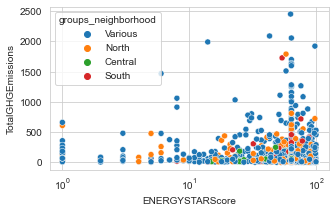

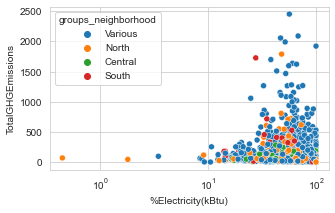

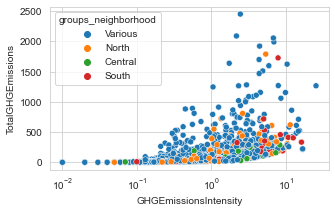

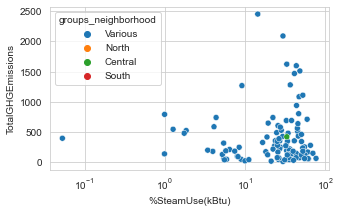

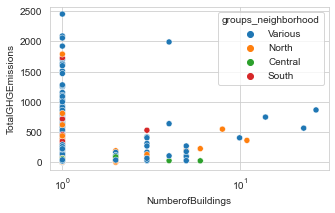

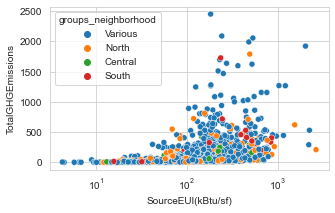

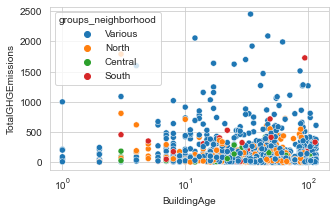

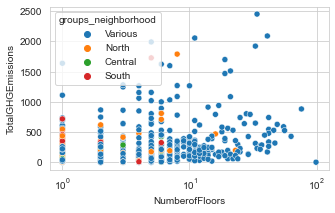

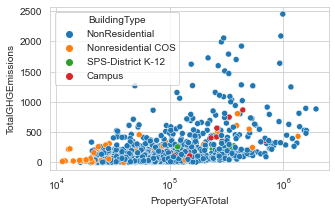

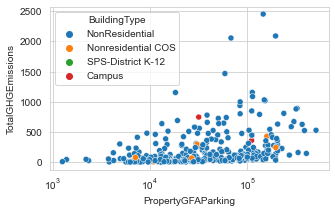

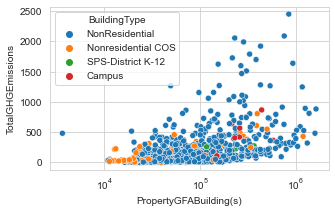

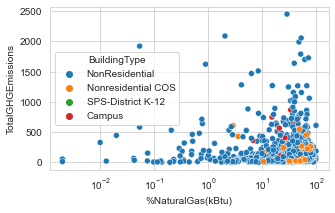

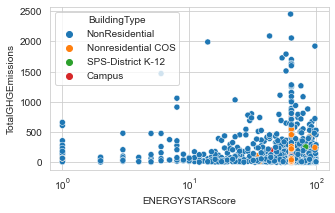

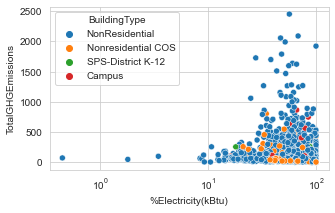

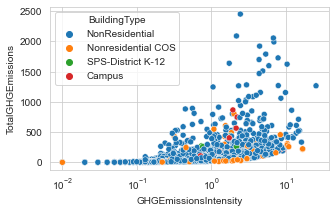

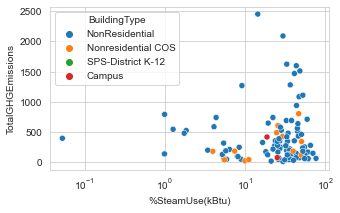

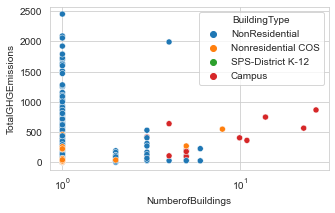

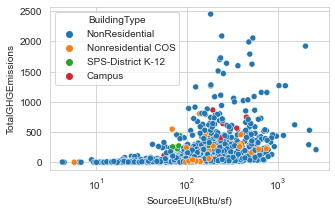

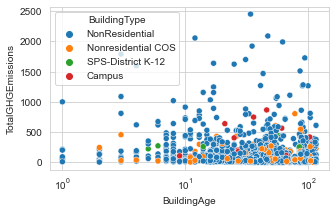

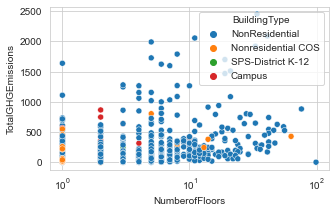

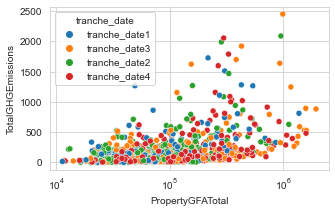

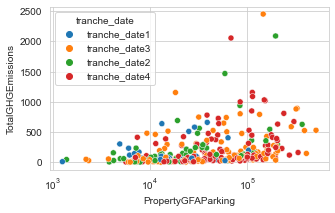

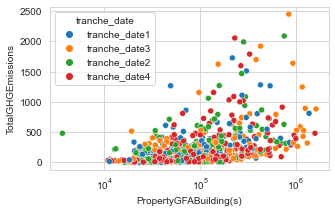

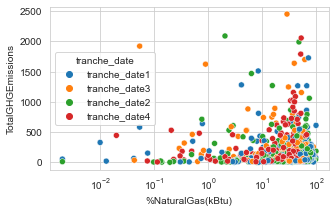

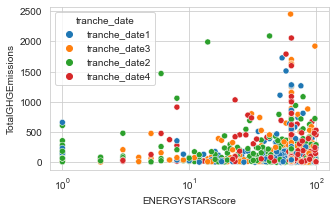

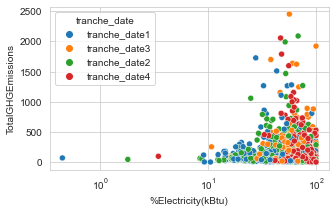

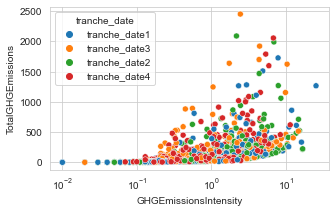

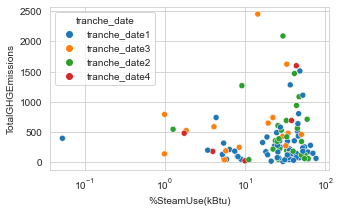

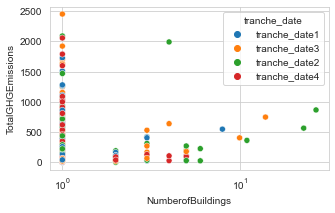

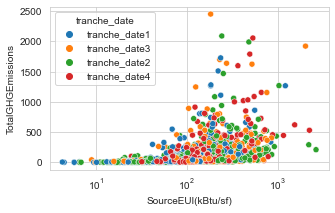

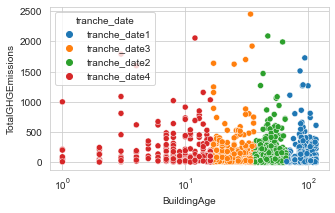

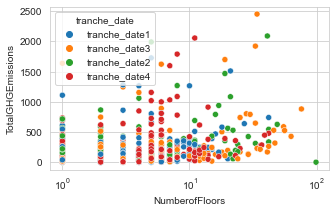

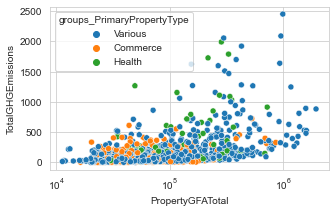

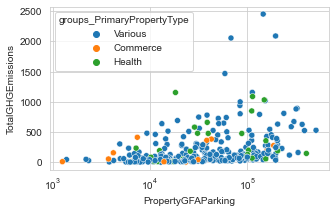

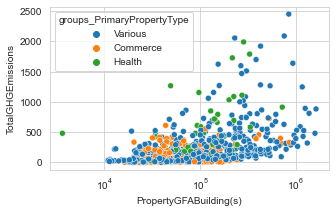

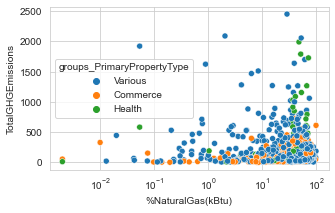

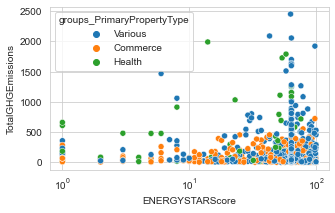

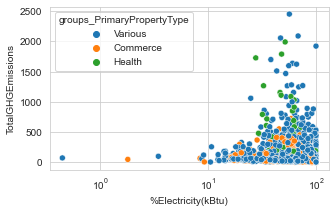

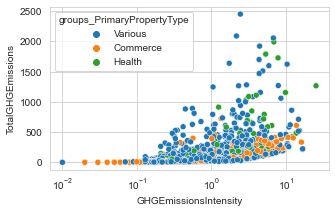

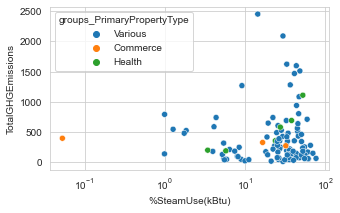

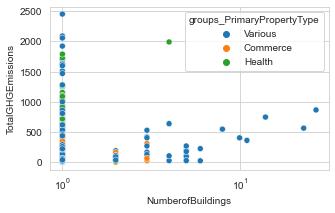

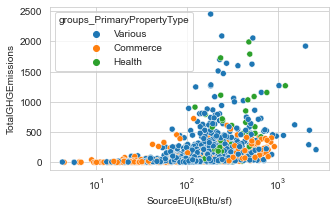

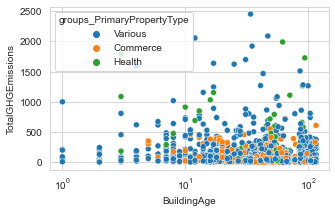

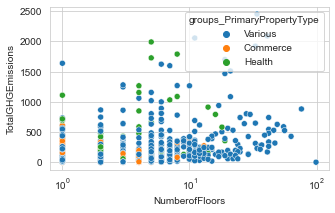

In [82]:
#target1
for h in cat_cols_scatter:
    for column in var_to_scatter_targets:
        plot_scatter(h,column,target1)

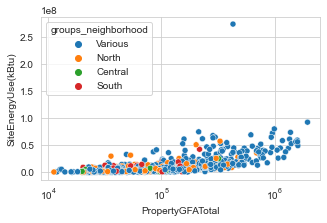

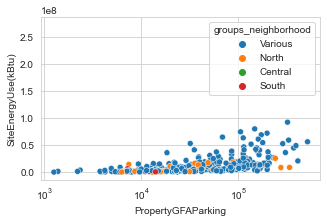

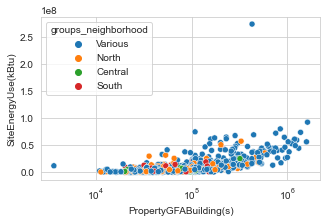

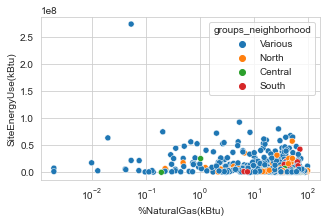

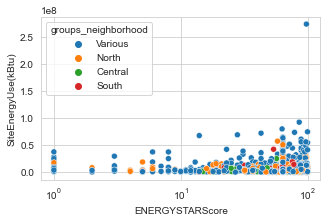

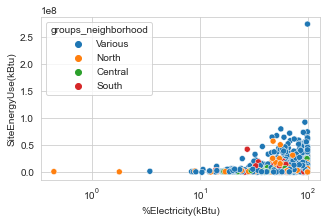

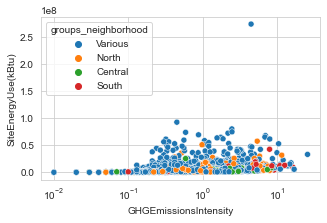

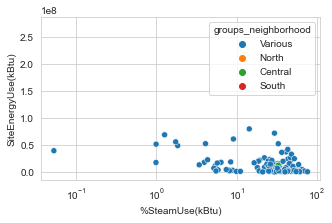

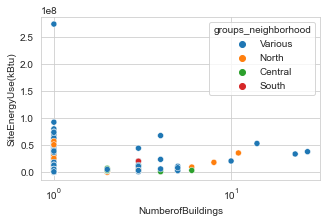

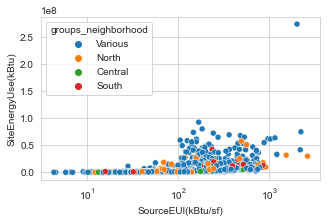

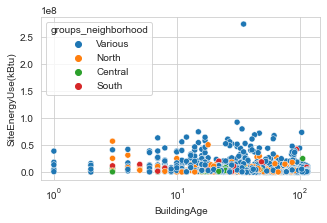

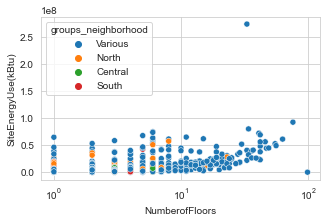

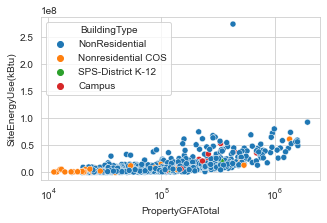

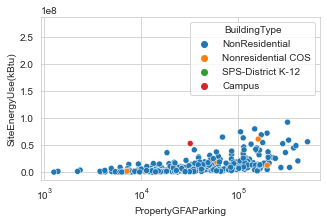

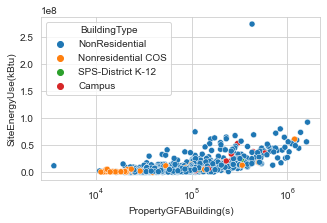

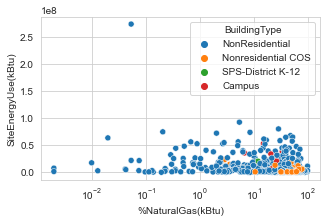

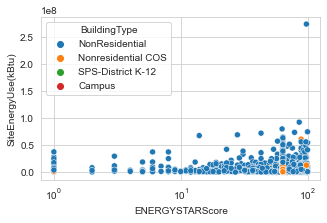

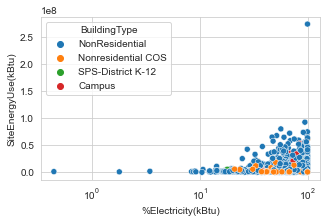

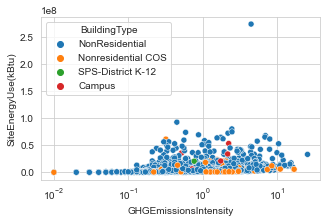

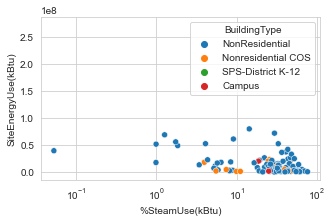

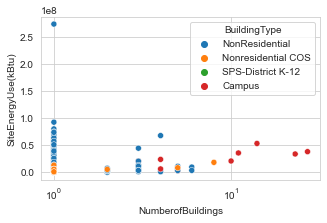

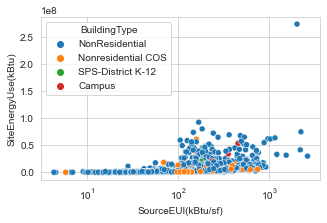

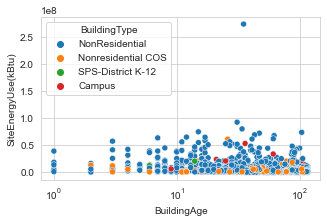

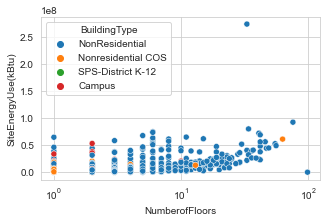

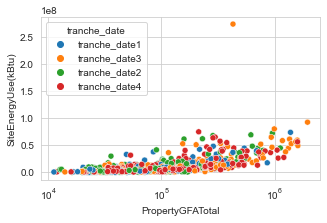

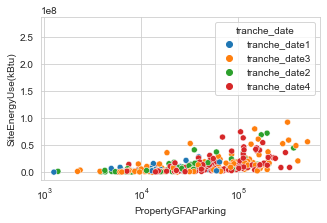

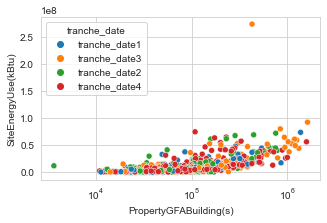

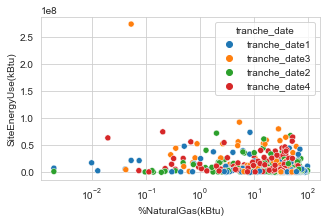

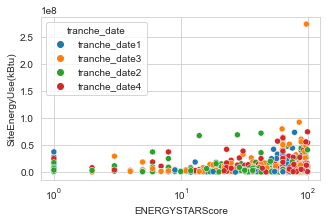

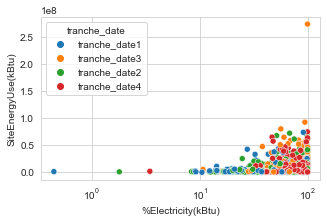

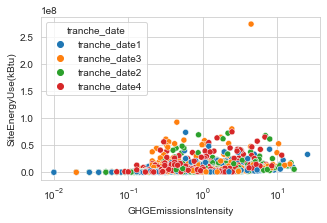

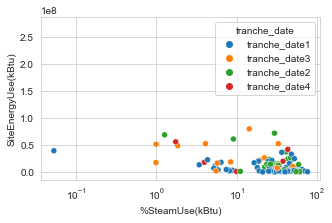

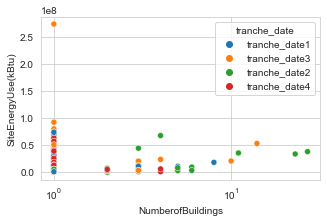

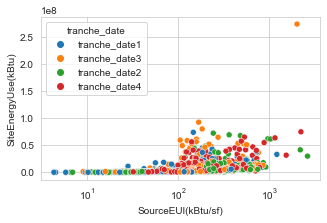

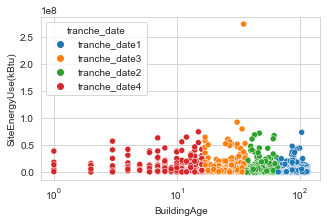

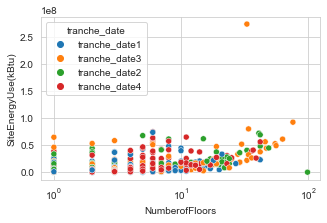

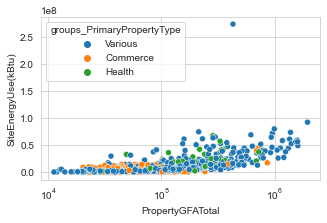

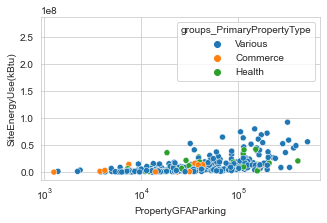

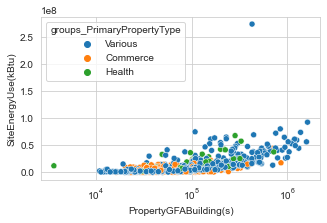

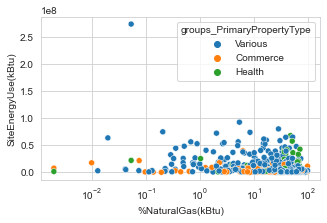

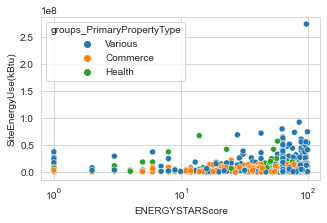

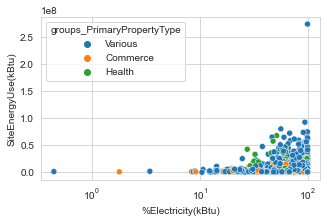

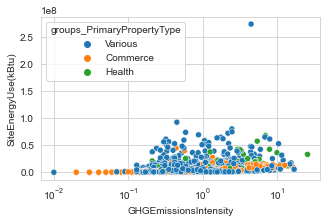

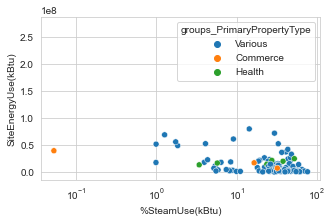

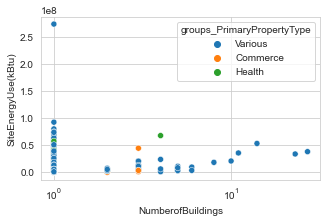

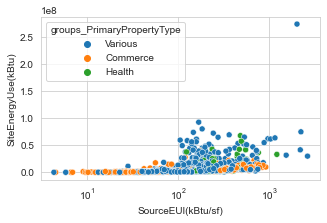

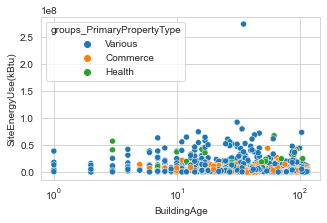

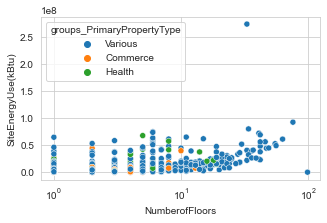

In [83]:
#target2
for h in cat_cols_scatter:
    for column in var_to_scatter_targets:
        plot_scatter(h,column,target2)

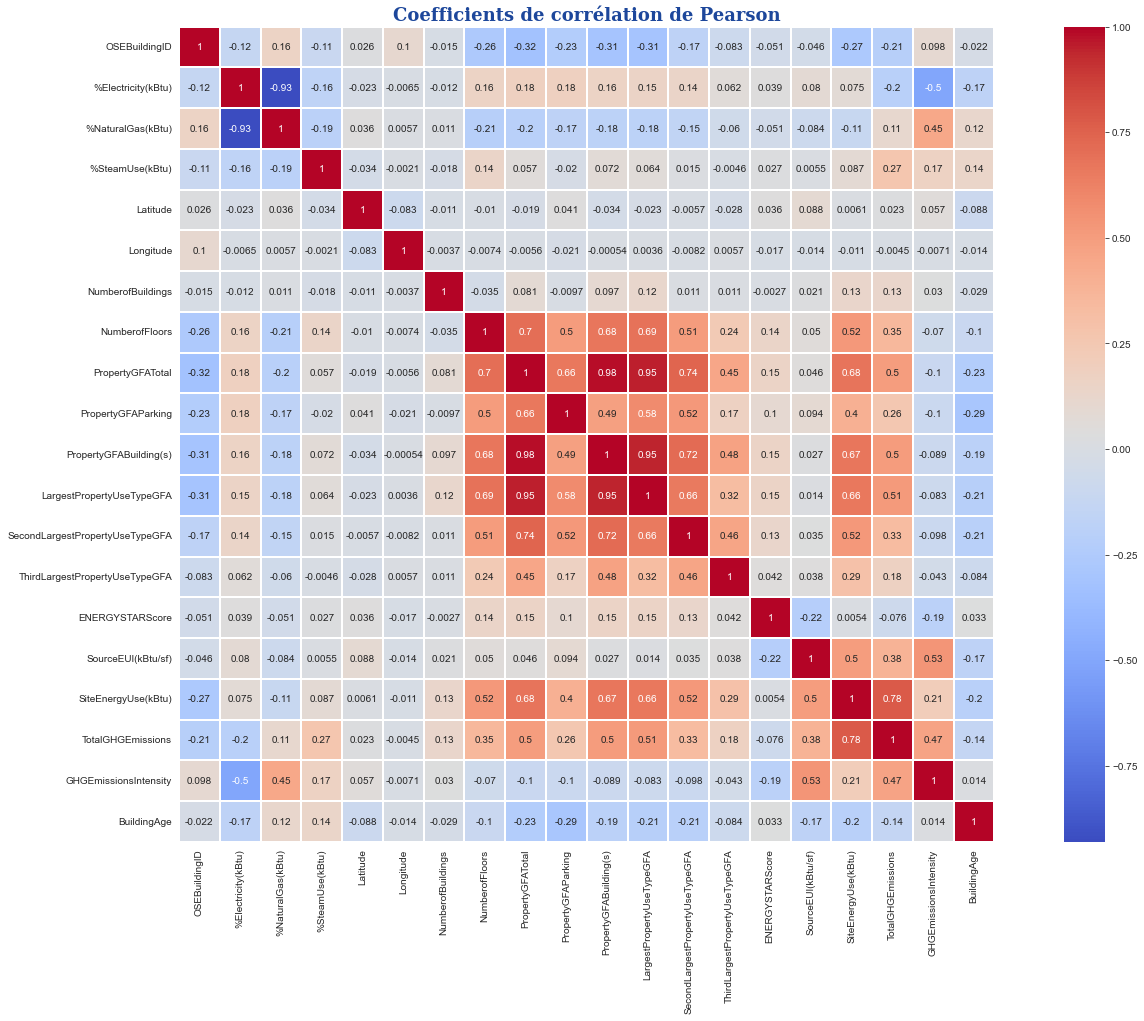

In [84]:
#look for correlated variables
fig=plt.figure(figsize=(25,15))

corr_mat = df.corr()
sns.heatmap(corr_mat, square=True, linewidths=0.01, annot=True, cmap='coolwarm')
plt.title("Coefficients de corrélation de Pearson", fontdict=font_title)
plt.show()

In [85]:
f_strong_correlation(0.7 ,df)

level_0                          level_1  \
0                 %NaturalGas(kBtu)               %Electricity(kBtu)   
2                    NumberofFloors                 PropertyGFATotal   
4   SecondLargestPropertyUseTypeGFA           PropertyGFABuilding(s)   
6                  PropertyGFATotal  SecondLargestPropertyUseTypeGFA   
8                 TotalGHGEmissions              SiteEnergyUse(kBtu)   
10           PropertyGFABuilding(s)        LargestPropertyUseTypeGFA   
12                 PropertyGFATotal        LargestPropertyUseTypeGFA   
14                 PropertyGFATotal           PropertyGFABuilding(s)   

    corr_coeff  
0    -0.930237  
2     0.702234  
4     0.716156  
6     0.742546  
8     0.776243  
10    0.947196  
12    0.954635  
14    0.977386

**Note**
<br>
LEs  variables suffixées GFA présentent de fortes corrélations avec plusieurs autres variables. Nous allons donc créer de nouvelles variables pour tenter d'éviter ces corrélations linéaires :

In [86]:
def split_words(df, column = None):
    list_words = set()
    for word in df[column].str.split(','):
        if isinstance(word, float):
            continue
        list_words = set().union(word, list_words)
    return list(list_words)

list_use_type = split_words(df, 'ListOfAllPropertyUseTypes')
print("Nombre de type d'usages dans la base : {}".format(len(list_use_type)))

Nombre de type d'usages dans la base : 113


**Note**
<br>
Afin de préparer un OneHotEncoder, nous allons créer une variable donnant le nombre total d'usages du bâtiment, puis supprimer la liste complète des usages :

In [87]:
df['TotalUseTypeNumber'] = [str(word).count(",") + 1 for word in df['ListOfAllPropertyUseTypes'].str.split(',')]
df.drop('ListOfAllPropertyUseTypes', axis=1, inplace=True)

In [88]:
gfa_features = find_component(df, suffix='GFA')
df[['TotalUseTypeNumber'] + gfa_features].head(5)

TotalUseTypeNumber  PropertyGFATotal  PropertyGFAParking  \
0                   1             88434                   0   
1                   3            103566               15064   
2                   1            956110              196718   
3                   1             61320                   0   
4                   3            175580               62000   

   PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
0                   88434                    88434.0   
1                   88502                    83880.0   
2                  759392                   756493.0   
3                   61320                    61320.0   
4                  113580                   123445.0   

   SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  
0                     36266.253021                    15054.316181  
1                     15064.000000                     4622.000000  
2                     36266.253021                    15054.316181  
3                     36266.253021                    15054.316181  
4                     68009.000000                        0.000000

In [89]:
df['PropertyGFABuilding(s)']

0        88434
1        88502
2       759392
3        61320
4       113580
         ...  
3370     18261
3372     16000
3373     13157
3374     14101
3375     18258
Name: PropertyGFABuilding(s), Length: 1541, dtype: int64

In [90]:
# Calcul des ratios
df['GFABuildingRate'] = (round(df['PropertyGFABuilding(s)']
                                  /df['PropertyGFATotal'],3))
df['GFAParkingRate'] = (round(df['PropertyGFAParking']
                                 /df['PropertyGFATotal'],3))

# Suppression des variables inutiles
df.drop(['LargestPropertyUseTypeGFA',
          'LargestPropertyUseType',
           'SecondLargestPropertyUseTypeGFA',
           'SecondLargestPropertyUseType',
           'ThirdLargestPropertyUseTypeGFA',
           'ThirdLargestPropertyUseType',
           'PropertyGFAParking',
           'PropertyGFABuilding(s)'],
         axis=1, inplace=True)




**Note**
<br>
vérifions la corrélation

In [91]:
f_strong_correlation(0.7 ,df)

level_0             level_1  corr_coeff
0      GFABuildingRate      GFAParkingRate   -1.000000
2    %NaturalGas(kBtu)  %Electricity(kBtu)   -0.930237
4     PropertyGFATotal      NumberofFloors    0.702234
6  SiteEnergyUse(kBtu)   TotalGHGEmissions    0.776243

**Note**
en se basant sur le tableau ci dessous je supprime dans la suite GFAParkingRate et %Electricity(kBtu)

In [92]:
df.drop(['GFAParkingRate','%Electricity(kBtu)'],axis=1,inplace=True)

In [93]:
df.columns

Index(['OSEBuildingID', '%NaturalGas(kBtu)', '%SteamUse(kBtu)', 'BuildingType',
       'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'ENERGYSTARScore', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'tranche_date', 'BuildingAge', 'groups_neighborhood',
       'groups_PrimaryPropertyType', 'TotalUseTypeNumber', 'GFABuildingRate'],
      dtype='object')

In [94]:
cols_to_keep=['OSEBuildingID', '%NaturalGas(kBtu)', '%SteamUse(kBtu)', 'BuildingType',
        'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'ENERGYSTARScore',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'tranche_date', 'BuildingAge',
       'groups_neighborhood', 'groups_PrimaryPropertyType',
        'GFABuildingRate']
df=df[cols_to_keep]

In [95]:
df.columns

Index(['OSEBuildingID', '%NaturalGas(kBtu)', '%SteamUse(kBtu)', 'BuildingType',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'ENERGYSTARScore', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'tranche_date',
       'BuildingAge', 'groups_neighborhood', 'groups_PrimaryPropertyType',
       'GFABuildingRate'],
      dtype='object')

# 5.Sauvegarde des données dans un fichier csv<a class="anchor" id="cs"></a>

In [96]:
#sauvegarde des données cleanées

df.to_csv('data1.csv', sep='\t',index=False)

In [97]:
df1=df.copy()

In [98]:
#num_feats = df[df.dtypes.dtypes!="object"].index
num_feats = [col for col in df1.columns if df1[col].dtype!="O"]
num_feats=set(num_feats)-set(['OSEBuildingID'])



In [99]:

df_high_skew=f_high_skewed_feature(df,num_feats,threshold=0.3)
df_high_skew

Feature  Skew_value
0       NumberofBuildings   16.698428
1     SiteEnergyUse(kBtu)    8.018692
2          NumberofFloors    5.875640
3      SourceEUI(kBtu/sf)    5.038893
4        PropertyGFATotal    4.760325
5         %SteamUse(kBtu)    4.746372
6       TotalGHGEmissions    4.365528
7   GHGEmissionsIntensity    3.745330
8       %NaturalGas(kBtu)    0.516510
9         ENERGYSTARScore   -0.848624
10        GFABuildingRate   -2.360773

In [100]:
variables_hig_skew=list(df_high_skew['Feature'])
variables_hig_skew

['NumberofBuildings',
 'SiteEnergyUse(kBtu)',
 'NumberofFloors',
 'SourceEUI(kBtu/sf)',
 'PropertyGFATotal',
 '%SteamUse(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 '%NaturalGas(kBtu)',
 'ENERGYSTARScore',
 'GFABuildingRate']

Skewness of NumberofBuildings was 16.7 before & is 5.69 after boxcox transformation.
Skewness of SiteEnergyUse(kBtu) was 8.02 before & is 0 after boxcox transformation.
Skewness of NumberofFloors was 5.88 before & is 0.34 after boxcox transformation.
Skewness of SourceEUI(kBtu/sf) was 5.04 before & is 0.0 after boxcox transformation.
Skewness of PropertyGFATotal was 4.76 before & is 0 after boxcox transformation.
Skewness of %SteamUse(kBtu) was 4.75 before & is 3.54 after boxcox transformation.
Skewness of TotalGHGEmissions was 4.37 before & is 0.0 after boxcox transformation.
Skewness of GHGEmissionsIntensity was 3.75 before & is 0.12 after boxcox transformation.
Skewness of %NaturalGas(kBtu) was 0.52 before & is 0.29 after boxcox transformation.
Skewness of ENERGYSTARScore was -0.85 before & is -0.03 after boxcox transformation.
Skewness of GFABuildingRate was -2.36 before & is -1.78 after boxcox transformation.


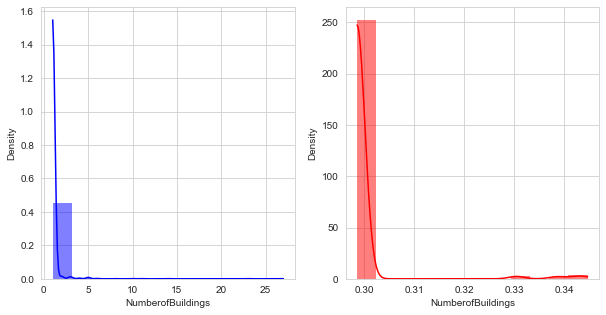

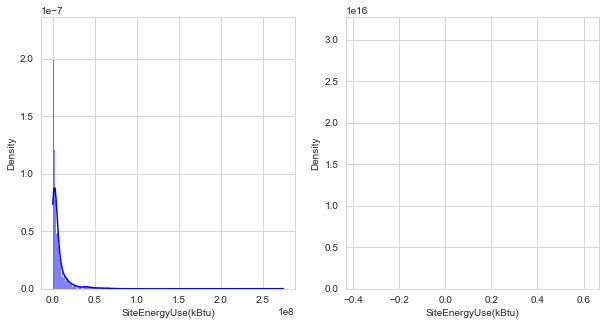

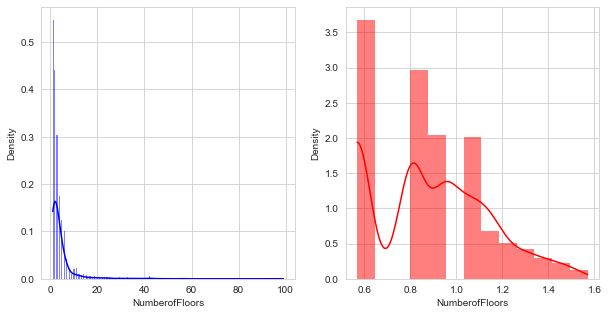

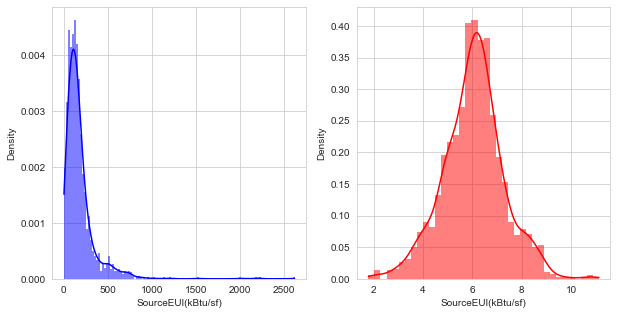

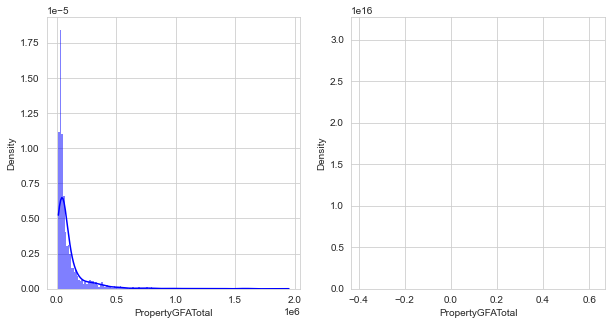

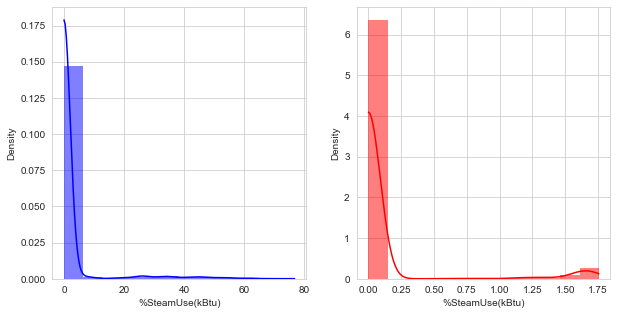

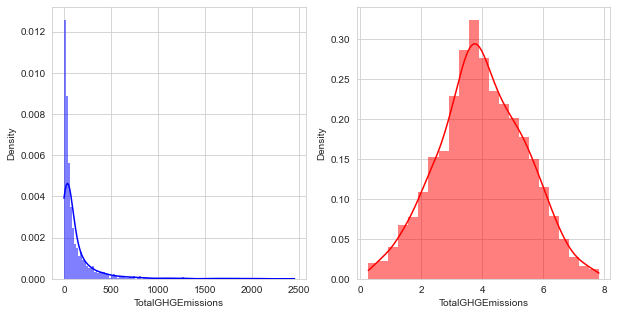

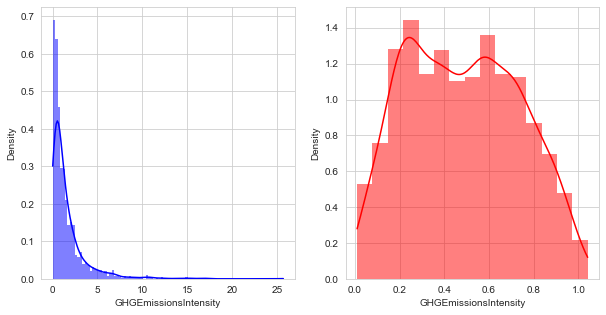

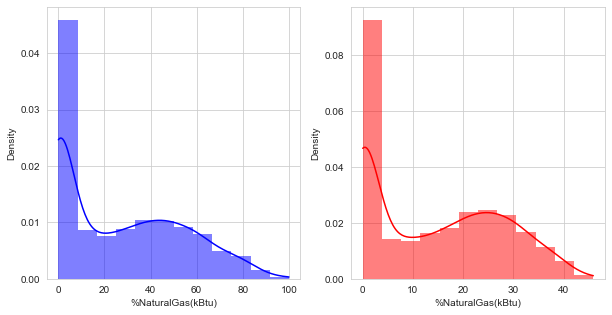

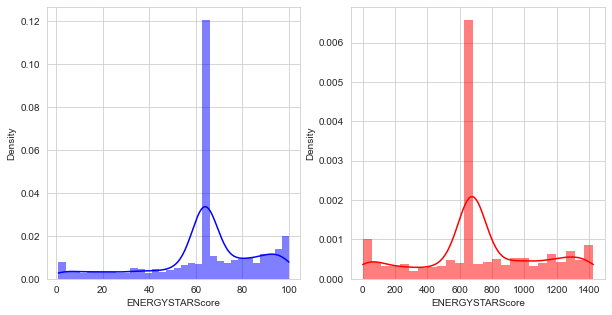

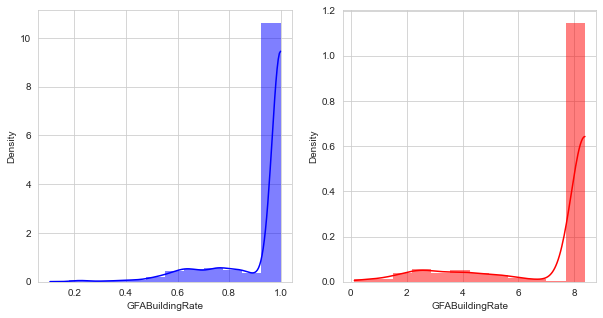

In [101]:
#transformation1:boxcox

df_boxcox1=f_transf_skew(df.copy(),variables_hig_skew,'boxcox')

Skewness of NumberofBuildings was 16.7 before & is 5.58 after quantile transformation.
Skewness of SiteEnergyUse(kBtu) was 8.02 before & is -0.0 after quantile transformation.
Skewness of NumberofFloors was 5.88 before & is -0.78 after quantile transformation.
Skewness of SourceEUI(kBtu/sf) was 5.04 before & is -0.01 after quantile transformation.
Skewness of PropertyGFATotal was 4.76 before & is -0.01 after quantile transformation.
Skewness of %SteamUse(kBtu) was 4.75 before & is 3.42 after quantile transformation.
Skewness of TotalGHGEmissions was 4.37 before & is -0.01 after quantile transformation.
Skewness of GHGEmissionsIntensity was 3.75 before & is -0.19 after quantile transformation.
Skewness of %NaturalGas(kBtu) was 0.52 before & is -0.74 after quantile transformation.
Skewness of ENERGYSTARScore was -0.85 before & is 0.54 after quantile transformation.
Skewness of GFABuildingRate was -2.36 before & is -1.43 after quantile transformation.


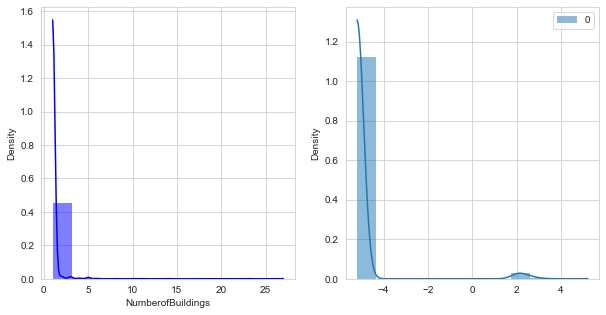

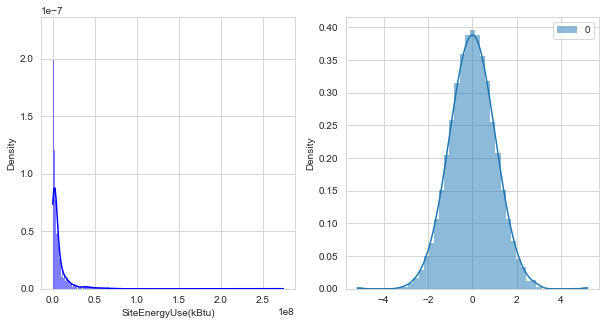

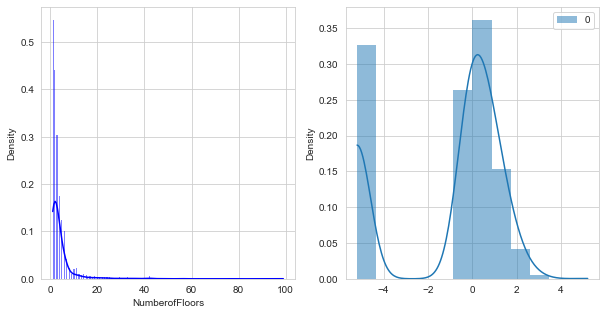

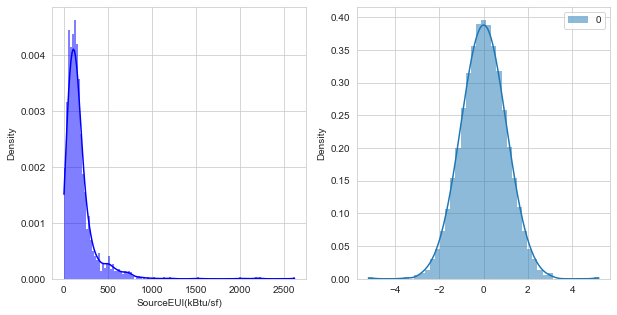

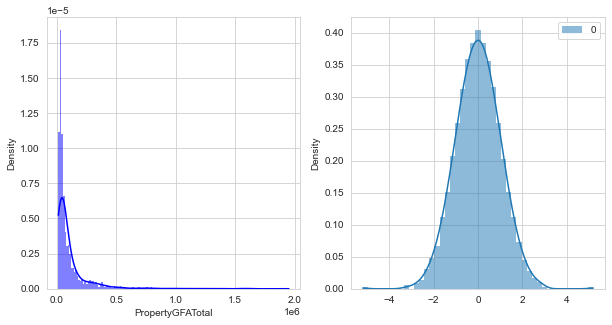

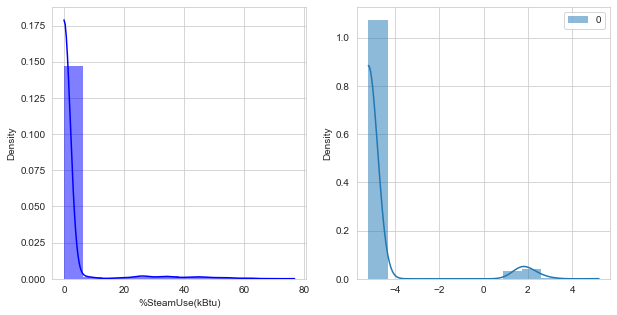

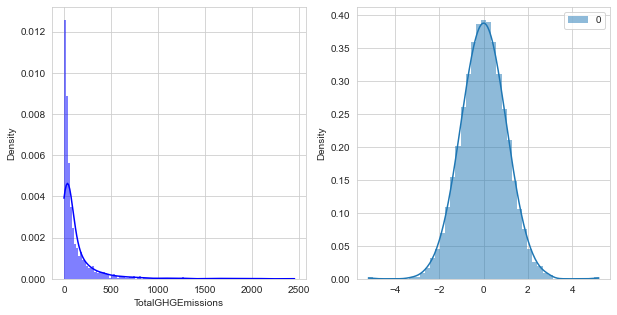

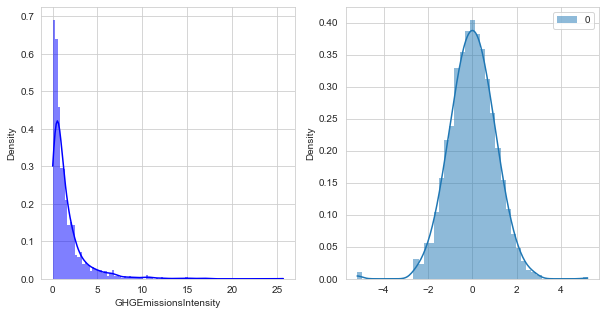

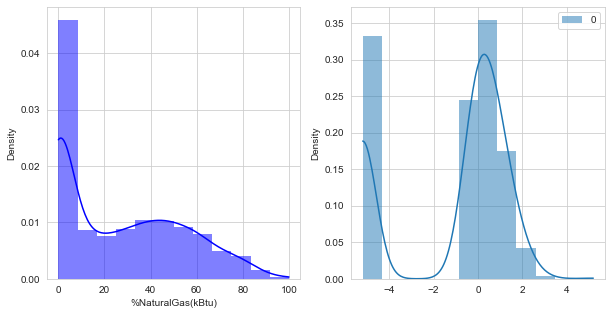

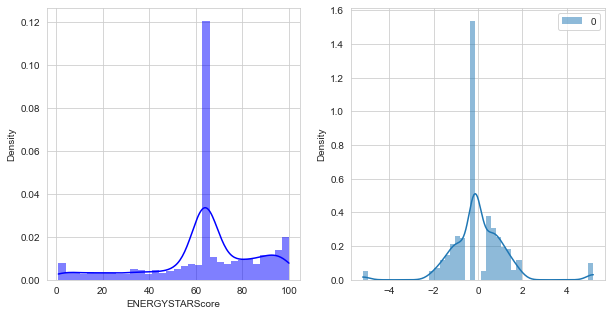

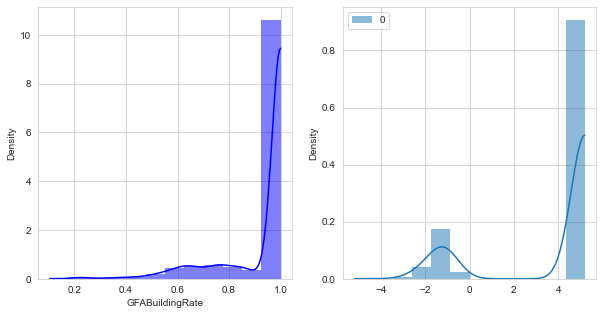

In [102]:
#transformation2:boxcox

df_quantile=f_transf_skew(df.copy(),variables_hig_skew,'quantile')

Skewness of NumberofBuildings was 16.7 before & is 8.63 after log transformation.
Skewness of SiteEnergyUse(kBtu) was 8.02 before & is 0.15 after log transformation.
Skewness of NumberofFloors was 5.88 before & is 1.39 after log transformation.
Skewness of SourceEUI(kBtu/sf) was 5.04 before & is -0.29 after log transformation.
Skewness of PropertyGFATotal was 4.76 before & is 1.02 after log transformation.
Skewness of %SteamUse(kBtu) was 4.75 before & is 3.73 after log transformation.
Skewness of TotalGHGEmissions was 4.37 before & is -0.0 after log transformation.
Skewness of GHGEmissionsIntensity was 3.75 before & is 1.1 after log transformation.
Skewness of %NaturalGas(kBtu) was 0.52 before & is -0.43 after log transformation.
Skewness of ENERGYSTARScore was -0.85 before & is -2.94 after log transformation.
Skewness of GFABuildingRate was -2.36 before & is -2.65 after log transformation.


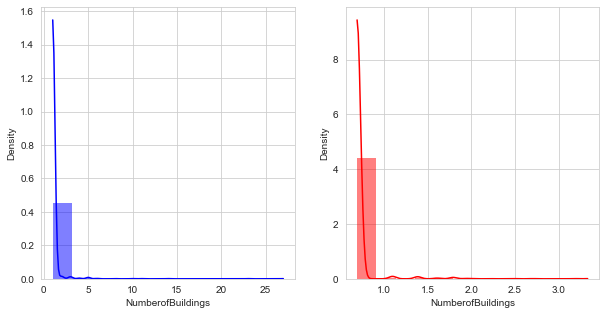

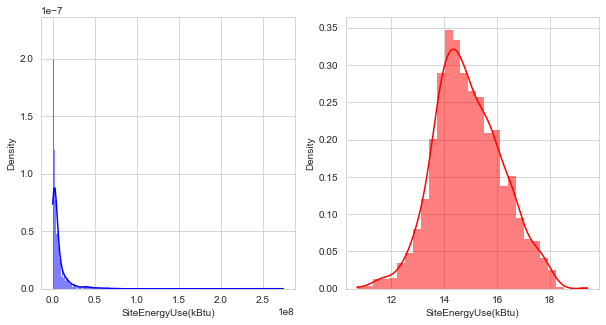

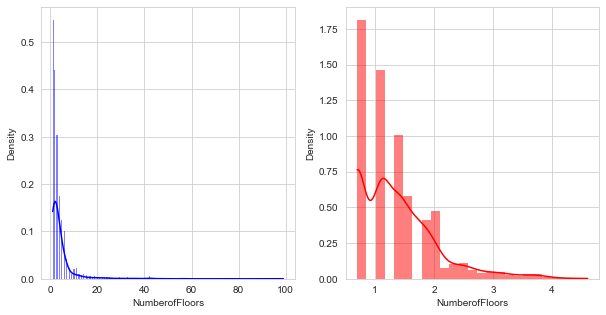

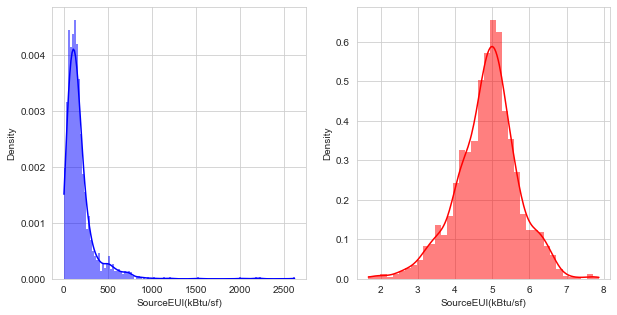

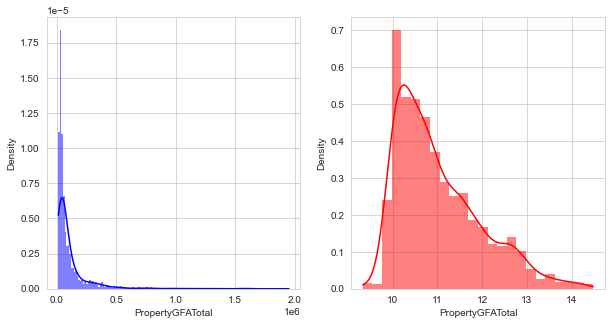

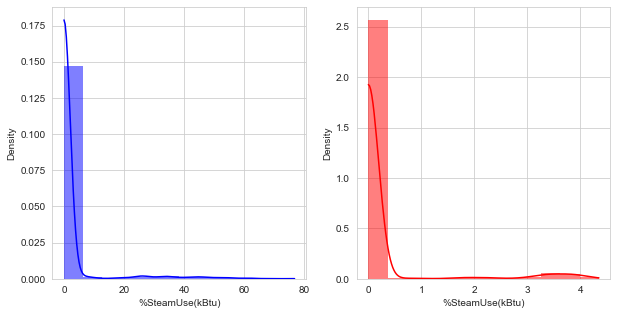

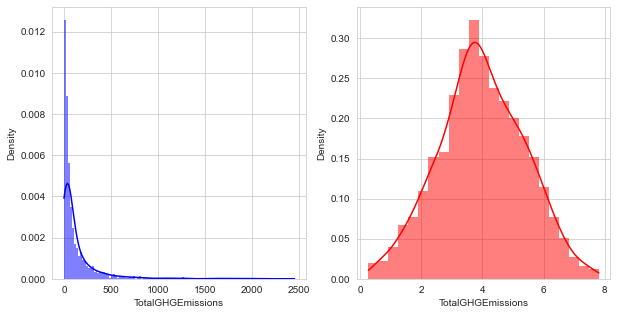

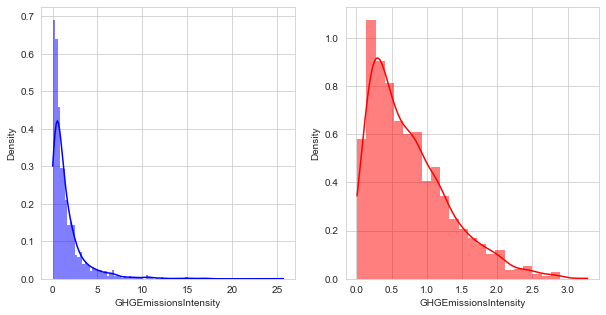

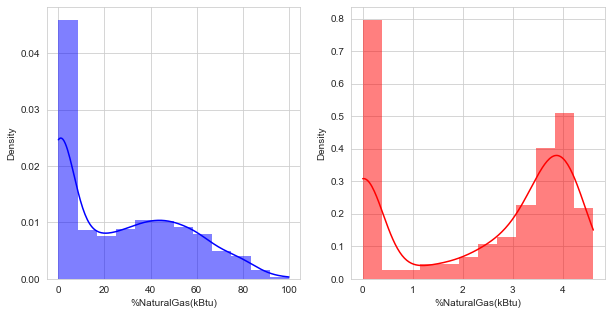

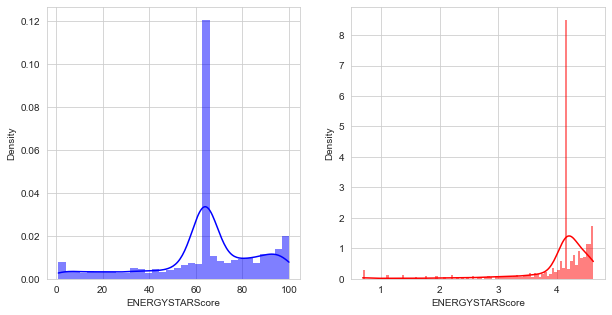

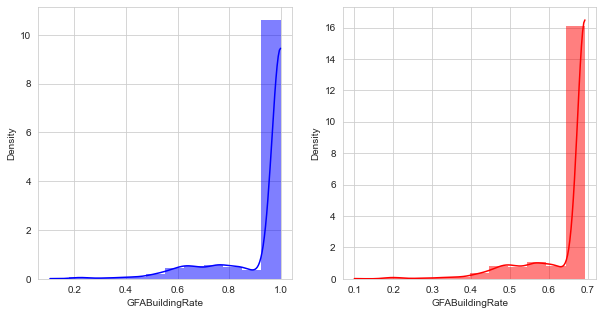

In [103]:
#transformation3:log(x+1)

df_log=f_transf_skew(df.copy(),variables_hig_skew,'log')

In [104]:
#df1.to_csv('not_skewed_test.csv', sep='\t',index=False)

In [107]:
list(df_quantile.columns)

['OSEBuildingID',
 '%NaturalGas(kBtu)',
 '%SteamUse(kBtu)',
 'BuildingType',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SourceEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'tranche_date',
 'BuildingAge',
 'groups_neighborhood',
 'groups_PrimaryPropertyType',
 'GFABuildingRate']

In [106]:
df_quantile.to_csv('df_quantile.csv', sep='\t',index=False)